# How Many Events Are Good Enough?
The number of events directly affects the length of training. This notebook will explore a bit how the performance varies as the number of events. There are two things that need to be explored to understand this:

- How stable is a run?
- How many events are needed?

## Initalization

In [6]:
from bdt_training_scikit_tools import plot_training_performance, load_default_samples, test_train_samples, prep_samples, default_training, calc_performance, calc_performance_for_run
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Load Data Samples
Load all the data we need.

In [70]:
def fraction (fractionGoal):
    '''Return a function that will take from a randomly distributed number a fraction of events.
    Meant to be used against an EventNumber to evenly pair down the number of events.
    
    Args
        fractionGoal - the fraction of events we'd like to see
        
    Returns
        func - A function that will return True or False when given an event number. True, then keep the event.
    '''
    if (fractionGoal < 0) | (fractionGoal > 1.0):
        raise Exception("Fraction must be between 0.0 and 1.0 (not {0})".format(fractionGoal))
        
    seq = ()
    fg = fractionGoal
    maxCount = 300
    for i in range(1, maxCount):
        frac = 1.0/i
        if frac <= fg:
            seq = seq + (i,)
            remainingSequence = [i for i in range(maxCount) if len([j for j in seq if i%j == 0]) != 0]
            actualFraction = len(remainingSequence)/maxCount
            fg = fractionGoal - actualFraction

    return seq
    #return lambda x: len([i for i in seq if x%i == 0]) != 0
    #return lambda x: x%i == 0

In [128]:
all_events = load_default_samples("24")

BIB: 600000 events
Multijet: 600000 events
Signal: 600000 events


Some memory load information from the above. These numbers are pulled from the task manager display on Windows 10, Fall creators update.

- 100K events each for BIB, MJ, and Signal: 275 MB
- 600K events each for BIB, MJ, and Signal: 600 MB

In [83]:
def calcDFFilter (df, seq):
    gf, *gfRest = [df.EventNumber%i==0 for i in seq]
    for g in gfRest:
        gf = gf | g
    return gf

def get_fraction_of_events(events, fractionToUse):
    '''Return a fraction of all events as training and testing samples.
    
    Args
        fractionToUse - fraction of the full datasample we should be using
        
    Returns
        training - Training tripple of events (bib, mj, sig)
        testing - Testing tripple of events (bib, mj, sig)
    
    '''
    # Create the per event filter. We have to do this against each
    # of the three input samples.
    seq = fraction(fractionToUse)
    fracFilters = [calcDFFilter(df, seq) for df in events]

    fraction_events = [dfi[1][dfi[0]] for dfi in zip(fracFilters,events)]
    return test_train_samples(fraction_events)

## Stability
Look at the stability of a run by repeating a training for a given fraction of events

In [38]:
def stability_run (train, testing, nRuns):
    '''Run the same training n-times
    
    Args
        train - (bib, mj, sig), which each one the full DF of all events to train on (including weights)
        testing - (bib, mj, sig), which each one the full DF of all events to train on (including weights)
        nRuns - How many times shall we repeat the training?
    
    Results
        [i,...] - i is the dict from calc_performance with all the results
    
    '''
    
    # Prep the events for running
    all_events, all_events_class, training_weight, evaluation_weight = prep_samples(train[0], train[1], train[2])
    
    # Build a list of the results
    return [calc_performance(default_training(all_events, training_weight, all_events_class), testing) for i in range(nRuns)]

In [39]:
training, testing = get_fraction_of_events(all_events, 0.5)

In [49]:
%%time
r = stability_run(training, testing, 10)

Wall time: 2min 55s


In [50]:
results = pd.DataFrame(r)
results.HSSSsqrtB

0    14.093197
1    14.093197
2    14.093197
3    14.093197
4    14.093197
5    14.093197
6    14.093197
7    14.093197
8    14.093197
9    14.093197
Name: HSSSsqrtB, dtype: float64

Conclusion from this: *BDT Boosting is deterministic*

- We don't have to worry about multiple runs to tell things apart
- We do have to be a little more serious about how we treat differences between runs now.

## Evolution of S/sqrt(B) with number of events
The real question here is: how few events can we run on?

- We really want to be able to remove variables from the training with as few events as possible and get reasonable results
- We can also look at the stability of the S/sqrt(B) as a function of the number of events.

We'll start with the simple stuff. How does the number of s/sqrtB evolve with the number of events?

In [133]:
def run_trends (events, fraction_list):
    '''Run the same training, and split events each time
    
    Args
        events - (bib, mj, sig), all events (will be split as usual into test and train)
        fraction_list - a list of floating (0.0-1.0) of the number of events we want to look at
    
    Results
        dict - dict of dicts. Indexed by # of training events for signal, and the dict is the usual
                output of calc_performance.
    
    '''
    
    result = {}
    train_all, test_all = get_fraction_of_events(events, 1.0)

    for f in fraction_list:
        train, test = get_fraction_of_events(events, f)
    
        # Prep the events for running
        all_events, all_events_class, training_weight, evaluation_weight = prep_samples(train[0], train[1], train[2])
    
        # Build a list of the results
        r = calc_performance(default_training(all_events, training_weight, all_events_class), test_all)
        result[len(all_events[all_events_class.Class == 2].index)] = r
        
    return result

In [134]:
%%time
r = run_trends(all_events, [1.0, 0.75, 0.50, 0.30, 0.20, 0.10])

Wall time: 3h 11min 51s


In [135]:
rdf = pd.DataFrame(r)
rdf

,39585,79716,105097,199406,296957,399384
BIBBack,1.373959e+08,1.133564e+08,1.095078e+08,9.425837e+07,9.091267e+07,8.716035e+07
BIBEff,6.710941e-01,6.474090e-01,6.356415e-01,6.505684e-01,6.438198e-01,6.285180e-01
BIBSsqrtB,1.145296e+01,1.216401e+01,1.215097e+01,1.340461e+01,1.350745e+01,1.346727e+01
BIBTotalCount,2.000420e+05,2.000420e+05,2.000420e+05,2.000420e+05,2.000420e+05,2.000420e+05
BIBTotalWeight,2.000420e+05,2.000420e+05,2.000420e+05,2.000420e+05,2.000420e+05,2.000420e+05
BIBinBIB,1.342470e+05,1.295090e+05,1.271550e+05,1.301410e+05,1.287910e+05,1.257300e+05
BIBinHSS,1.232700e+04,1.122600e+04,1.344900e+04,9.967000e+03,9.430000e+03,1.153600e+04
BIBinMJ,5.346800e+04,5.930700e+04,5.943800e+04,5.993400e+04,6.182100e+04,6.277600e+04
HSSBack,1.279677e+07,1.363390e+07,1.576522e+07,1.282616e+07,1.296408e+07,1.295227e+07
HSSEff,9.429507e-01,9.533238e-01,9.635224e-01,9.400546e-01,9.567931e-01,9.578747e-01


In [162]:
rdf.loc['MJinHSS']

39585     1.278444e+07
79716     1.362267e+07
105097    1.575177e+07
199406    1.281620e+07
296957    1.295465e+07
399384    1.294073e+07
Name: MJinHSS, dtype: float64

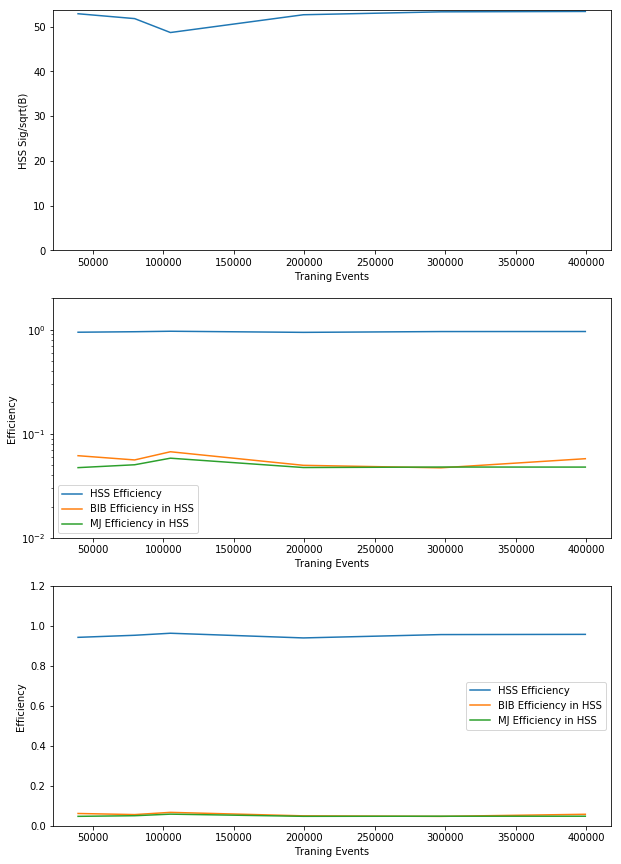

In [173]:
f = plt.figure(figsize=(10,15))
ax = plt.subplot(311)
plt.plot(rdf.columns, rdf.loc['HSSSsqrtB'])
ax.set_ylim(0.0, plt.ylim()[1])
ax.set_xlabel("Traning Events")
ax.set_ylabel("HSS Sig/sqrt(B)")

ax2 = plt.subplot(312)
plt.plot(rdf.columns, rdf.loc['HSSEff'], label='HSS Efficiency')
plt.plot(rdf.columns, rdf.loc['BIBinHSS']/rdf.loc['BIBTotalWeight'], label='BIB Efficiency in HSS')
plt.plot(rdf.columns, rdf.loc['MJinHSS']/rdf.loc['MJTotalWeight'], label='MJ Efficiency in HSS')
ax2.set_ylim(0.01, 2.0)
ax2.set_xlabel("Traning Events")
ax2.set_ylabel("Efficiency")
ax2.set_yscale('log')
ax2.legend()

ax2 = plt.subplot(313)
plt.plot(rdf.columns, rdf.loc['HSSEff'], label='HSS Efficiency')
plt.plot(rdf.columns, rdf.loc['BIBinHSS']/rdf.loc['BIBTotalWeight'], label='BIB Efficiency in HSS')
plt.plot(rdf.columns, rdf.loc['MJinHSS']/rdf.loc['MJTotalWeight'], label='MJ Efficiency in HSS')
ax2.set_ylim(0, 1.2)
ax2.set_xlabel("Traning Events")
ax2.set_ylabel("Efficiency")
ax2.legend()

plt.show()